In [241]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import nltk as nlp
import dask.dataframe as dd
from bs4 import BeautifulSoup

In [242]:
plt.rc("font",size = 15)
sns.set(style="dark")
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(10,10)})
%matplotlib inline
pd.set_option('display.max_columns',500)
import string

# read in data and overview 

we notice the following; 

1) we have no missing values 

2) our main columns are the title, subject, and the text of the article 

3) the titles of the fake news articles have many more capitalized words than the real ones 

4) the fake news have more subjects 

In [271]:
#reading in data 
fake = pd.read_csv('fake.csv')
real = pd.read_csv('true.csv')

In [273]:
# viewing the data 
def over(fake,real):
    print('Headers\n')
    display(fake.head(),real.head())
    
    print('Overview \n')
    display(fake.info())
    display(real.info())
    
    print('Null values \n')
    print('Fake News \n', fake.isna().sum())

    print('\nReal News \n',real.isna().sum())
over(fake,real)

Headers



,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


Overview 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


None

Null values 

Fake News 
 title      0
text       0
subject    0
date       0
dtype: int64

Real News 
 title      0
text       0
subject    0
date       0
dtype: int64


In [260]:
# Subject value counts
print('Real:\n',real.subject.value_counts().compute())
print('\nFake: \n',fake.subject.value_counts().compute())


Real:
 politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

Fake: 
 News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64


In [274]:
# category variable and combining  
fake['cat'] = 0 
real['cat'] = 1
data = pd.concat([real,fake])

# EDA 

Through our EDA we find the following 

1) our dataset is balanced and contains proportional amounts of both categories 

2) we have different subjects for each category so we should exclude them from our final analysis 

3) Looking at the counts of capital letters in our titles, we conclude that fake news articles contain many more capitalized words and this should be useful upon prediction 



In [36]:
import re 

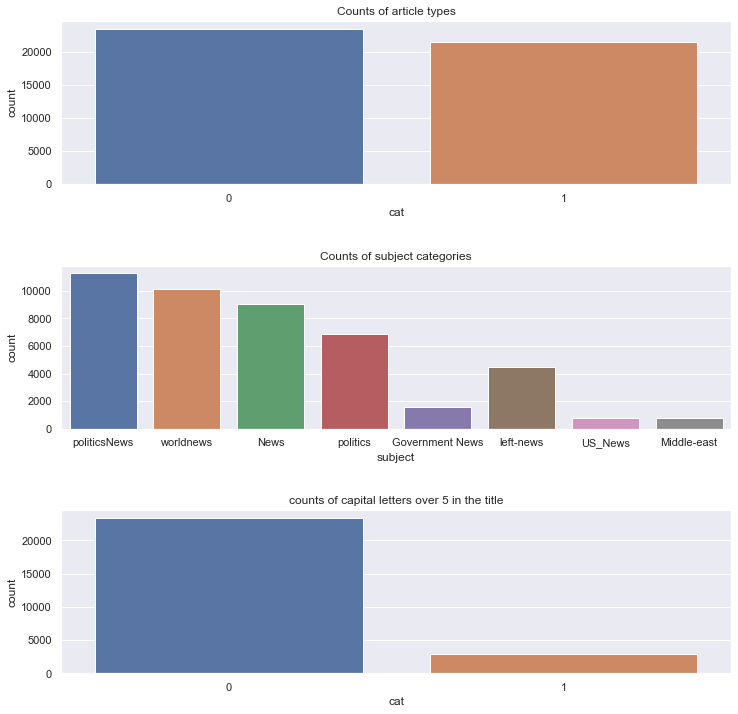

In [279]:
#visualizations 
fig, axs = plt.subplots(3,1,figsize = (12,12))
plt.subplots_adjust(wspace = 0.7,hspace = 0.5)
#looking at counts of article types 
sns.countplot(x = 'cat',data = data,ax = axs[0])
axs[0].set_title('Counts of article types')

#looking at subject types
sns.countplot(x = 'subject',data = data,ax =axs[1])
axs[1].set_title('Counts of subject categories')

#looking at counts of capital letters over 5 in the title 

sns.countplot(data = data.loc[data.cap_count > 5,:],x = 'cat',ax= axs[2])
axs[2].set_title('counts of capital letters over 5 in the title')
plt.show()

## finding counts of capital letters

In [278]:
#finding capital letter counts and creating a new feature 
fk_caps= data.loc[data['cat'] == 0,'title'].apply(lambda x: re.findall(r'^.*[A-Z]{5}.*$',x)).to_list()
real_caps = data.loc[data['cat'] == 1,'title'].apply(lambda x: re.findall(r'^.*[A-Z]{5}.*$',x)).to_list()
real_caps = [x for x in real_caps if x]
fk_caps = [x for x in fk_caps if x]
data['cap_count'] = data['title'].apply(lambda x: sum(1 for x in x if x.isupper()))

# PreProcessing 

In [280]:
#delete subject and date columns 
del data['subject']
del data['date']

In [281]:
#imports 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

## removing noise 

Here we accomplished the following: 

1) removed html tags 

2) removed stopwords (hashtags, and punctuations)

3) 

In [282]:
#setting up stop words
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [320]:
def dsk_clean(df): 
    df['text'] = df['text'].apply(lambda x: noise_removal(x,stop))
    df['title'] = df['title'].apply(lambda x: noise_removal(x,stop))
    return df

In [321]:
dsk = dd.from_pandas(data,npartitions=15) 

In [322]:
result = dsk.map_partitions(dsk_clean,meta = data)

In [323]:
dsk = result.compute()

In [326]:
# Removal 
def remove_stop(text,stop):
    final_text = []
    for word in word_tokenize(text): 
        if word.strip().lower() not in stop: 
            final_text.append(word.strip())
    return " ".join(final_text)

def remove_paran_brack(text): 
    text = re.sub(r'\([^)]+\)','',text)
    return re.sub(r'\[[^]]+\]','',text) 

def strip_html(text): 
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

def remove_html_url(text):
    #url 
    text = re.sub(r'http\S+','',text) 
    return text 

def noise_removal(text,stop): 
    text = remove_stop(text,stop)
    text = remove_paran_brack(text)
    text = remove_html_url(text)
    text = strip_html(text)
    return text 

#updating features 

data['text'] = data['text'].apply(lambda x: noise_removal(x,stop))
data['title'] = data['title'].apply(lambda x: noise_removal(x,stop))

## Lexicon Normalization 

In [328]:
#import 
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

In [357]:
#applying
lem = WordNetLemmatizer()
stem = PorterStemmer()

In [359]:
#lemmatize 
def lema(text): 
    text = text.split()
    new = [lem.lemmatize(x,'v') for x in text]
    return " ".join(new)

data['title'] = data['title'].apply(lambda x: lema(x))
data['text'] = data['text'].apply(lambda x: lema(x))

# Feature Eng and sklearn 

In [365]:
#tf-idf 
from sklearn.feature_extraction.text import TfidfVectorizer

In [450]:
def tf_transform(df, cols): 
    tf = TfidfVectorizer(strip_accents='ascii', 
                    stop_words='english',token_pattern= r'\w{2,}'
                    ,min_df = 0.15, max_df  = 1.0)
    new_df = pd.DataFrame()
    for col in cols: 
        to_transform = df[col].values
        tf_matrix = tf.fit_transform(to_transform)
        tf_matrix = tf_matrix.toarray()
        vocab = tf.get_feature_names()
        new_df = pd.DataFrame(tf_matrix,columns=vocab)
        
    
    return new_df

In [453]:
#transform
data_tf = tf_transform(data,['text'])
data_tf2 = tf_transform(data,['title'])

In [463]:
#joining 
data =data[['cat','cap_count']].join(data_tf)
data[['trump','video']] = data_tf2[['trump','video']]

## train-test split and modeling 

## Model and results 

We observe that our best model is LinearSVC; which accurately classified the real and fake news articles 99% of the time. 


In [495]:
#imports
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [478]:
x = data.drop('cat',axis = 1)
y = data.loc[:,'cat']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.3, random_state =0)

In [484]:
#models 
sgd = SGDClassifier(tol=None, random_state = 42)
svc = LinearSVC(random_state=42)
nb = BernoulliNB()

In [485]:
#fit 
sgd.fit(x_train,y_train)
svc.fit(x_train,y_train)
nb.fit(x_train,y_train)

/Applications/anaconda3/envs/Projects/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [492]:
#predictions 
nb_pred = nb.predict(x_test)
svc_pred = svc.predict(x_test)
sgd_pred = sgd.predict(x_test)

In [539]:
#scoring
preds = [nb_pred,svc_pred,sgd_pred]
models= ['NB','LinearSVC','SGD']
for pred,model in zip(preds,models):
    
    print(f"{model} classification report: \n{classification_report(y_test,pred)}")
    print('\n')
    print(f"{model} AUC Score: {roc_auc_score(y_test,pred)}\n")


NB classification report: 
              precision    recall  f1-score   support

           0       0.57      0.32      0.41      7041
           1       0.50      0.73      0.59      6429

    accuracy                           0.52     13470
   macro avg       0.53      0.53      0.50     13470
weighted avg       0.53      0.52      0.50     13470



NB AUC Score: 0.5269631979560023

LinearSVC classification report: 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7041
           1       0.99      0.99      0.99      6429

    accuracy                           0.99     13470
   macro avg       0.99      0.99      0.99     13470
weighted avg       0.99      0.99      0.99     13470



LinearSVC AUC Score: 0.9905047848867076

SGD classification report: 
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      7041
           1       0.98      0.99      0.98      6429

    accuracy  

# Feature eng and keras 

In [632]:
#import 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM
from tensorflow.keras.preprocessing import text, sequence 
from tensorflow.keras import utils 

In [609]:
# SHAPING AND INSTANTIATING
max_words = 1000 
data_keras = dsk[['text','cat','cap_count']]


x = data_keras.drop('cat',axis = 1)
y = pd.get_dummies(data = data_keras['cat'], columns = ['cat']).values

x_cap = pd.get_dummies(data = x['cap_count'],columns = ['cap_count']).values

token = text.Tokenizer(num_words = max_words)
token.fit_on_texts(x['text'])

In [610]:
#PADDING and converting to array 
x_text = token.texts_to_sequences(x['text'].values)
x_text = sequence.pad_sequences(x_text)

In [611]:
#x_array COMPLETE 
x = np.append(x_text, x_cap,axis = 1)

In [615]:
# train test split 
X_train, X_test, Y_train, Y_test = train_test_split(x,y,test_size = 0.3, random_state = 42)


In [622]:
X_train.shape

(31428, 2460)

In [655]:
# Build Model 
model = Sequential()
model.add(Dense(512, input_shape=(2460,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))



model.add(Dense(32)) #output layer
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('sigmoid'))

model.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics =['accuracy'])

history = model.fit(X_train,Y_train,batch_size = 256,epochs = 5, verbose = 1, validation_split = 0.1)

Epoch 1/5
111/111 [==============================] - 3s 28ms/step - loss: 2.3713 - accuracy: 0.5248 - val_loss: 0.6913 - val_accuracy: 0.5081
Epoch 2/5
111/111 [==============================] - 3s 23ms/step - loss: 0.7192 - accuracy: 0.5250 - val_loss: 0.6866 - val_accuracy: 0.5081
Epoch 3/5
111/111 [==============================] - 3s 23ms/step - loss: 0.7020 - accuracy: 0.5250 - val_loss: 0.6809 - val_accuracy: 0.5081
Epoch 4/5
111/111 [==============================] - 3s 23ms/step - loss: 0.6838 - accuracy: 0.5251 - val_loss: 0.6802 - val_accuracy: 0.5081
Epoch 5/5
111/111 [==============================] - 3s 23ms/step - loss: 0.7037 - accuracy: 0.5250 - val_loss: 0.6774 - val_accuracy: 0.5081


In [656]:
pred = model.evaluate(X_test,Y_test)

421/421 [==============================] - 2s 4ms/step - loss: 0.6771 - accuracy: 0.5225


In [657]:
pred[1]

0.5224944353103638